In [ ]:
import copy
from types import SimpleNamespace
import random
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd
import lrp
from sklearn.cluster import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

**add_client**
cette fonction insert un client dans une solution
entré : objecti.solution, position i,position j, position k, indice de client

In [ ]:
def add_client(solution, i, j,k, client):
    solution2 = solution.copy()  # Créer une copie de la liste solution
    solution2[i][j].insert(k, client)
    return solution2

**Trouver Position**

cette fonction rend la position d'un element (client ou dépot) dans une solution.

sortie : [i,j,k] ou [i,0] si l'element est un dépot, s'elle ne trouve pas le client dans la solution elle rend : None

element : indice

liste = solution d'un objet locationroutingproblem




In [ ]:
def trouver_position(element, liste, position=[]):
    for i, item in enumerate(liste):

        if item == element:
            return position + [i]
        elif isinstance(item, list):
            sous_position = trouver_position(element, item, position + [i])
            if sous_position is not None:
                return sous_position
    return None

**select_random_client**

choisi n clients dans une liste aléatoirement, si n > len(liste) il rend toute la liste
sortie : liste composée des indice de n clients sans répitition
entré : liste des indices des clients, n le nombre de client à chosir.

**supprimer_elements**

enleve une liste des clients dans une solution
sortie : solution sans client choisi
entré : elements à supprimés dans une liste, si un seul client à supprimer : [client]

In [ ]:
def selecte_random_client(liste ,n = 1):
    if len(liste) <= n:
        return random.sample(liste, len(liste))
    else:
        return random.sample(liste, n)

def supprimer_elements(liste1, elements_a_supprimer):
    resultat = []
    indice_supprime = None
    liste = liste1.copy()

    for element in liste:
        if isinstance(element, list):
            sous_liste = supprimer_elements(element, elements_a_supprimer)
            resultat.append(sous_liste)
        elif element not in elements_a_supprimer:
            resultat.append(element)
    return resultat

**random_removal**

supprime n elements aleatoirement.

entré : object de classe LRP

sortie : object avec les element suprimer dans unassigned client, et une liste des clients supprimer (n'est pas d'importance pour le code)

In [ ]:
def random_removal(problem,n=1):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = problem
    solution = destroyed.solution

    clients_deleted = selecte_random_client(destroyed.client_index,n)
    destroyed.solution = supprimer_elements(destroyed.solution,clients_deleted)
    problem.unassigned_client = clients_deleted
    return destroyed,clients_deleted,

**worst_removal_aleatoire**

calcule les coûts d'insertion de chaque client, et supprime p clients avec un coût d'insertion les plus elevé.

entré : object LRP, p nbr des clients à supprimer, seuil initial doit etre très elevé par rapport au coût initial

sortie : objet avec client supprimées et dans l'attribut Unassigned Clients, client supprimé dans une liste

à modifier : à la place de chosir 3 clients parmi les 3 premier à chaque iteration, veux mieux rajouter une perturbation

In [ ]:
import heapq



def worst_removal_aleatoire(problem, p=1, seuil_initial=99999999999999999):
    destroyed = problem
    solution = destroyed.solution
    localions = problem.locations
    initial_objective = objective(problem,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,False)
    seuil = initial_objective
    clients_deleted = []

    for iteration in range(p):
        objective_list = []  # Utiliser un tas pour conserver les 3 objectifs les plus élevés

        for i in range(len(solution)):
            for j in range(1, len(solution[i])):
                for k in range(len(solution[i][j])):
                    current_objective = optimised_objective(solution, localions, i, j, k, initial_objective)

                    # Mettre les objectifs dans le tas avec un signe négatif pour obtenir les plus élevés en premier
                    objective_list.append((current_objective, i,j,k))

        objective_list.sort()
        #for _, l, m, n in objective_heap:
        _,l,m,n = objective_list[random.randint(0,3-1)]
        clients_deleted.append(solution[l][m][n])
        del destroyed.solution[l][m][n]


        seuil = seuil_initial

    destroyed.unassigned_client = clients_deleted
    return destroyed, clients_deleted

**dbscan_clustering**

il classe les client par des region en utilisant dbscan clustering.
entré : object.locations, epsilon, et le nbr minimum de client pour creer une classe.
sortie : tableau, chaque ligne compose une classe, pour acceder à une classe : sortie[indiceClasse]

In [ ]:
def dbscan_clustering(locations, epsilon, min_samples):
    # Créer un tableau numpy à partir des listes clients_x et clients_y
    clients = locations

    # Initialiser l'algorithme DBSCAN
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

    # Effectuer le clustering sur les données des clients
    etiquettes_clusters = dbscan.fit_predict(clients)

    # Identifier le nombre de clusters (ignorer le label -1 qui correspond au bruit/noise)
    nombre_clusters = len(set(etiquettes_clusters)) - (1 if -1 in etiquettes_clusters else 0)

    # Créer une liste vide pour chaque classe de cluster
    clusters = [[] for _ in range(nombre_clusters)]

    # Parcourir les étiquettes de cluster et ajouter les indices des clients correspondants à la liste appropriée
    for indice_client, etiquette_cluster in enumerate(etiquettes_clusters):
        if etiquette_cluster != -1:  # Ignorer les points considérés comme du bruit/noise
            clusters[etiquette_cluster].append(indice_client)

    # Retourner la liste des clusters
    return clusters

**Kmean_clustering**
comme le dbScan, mais ici il faut un nombre de classe

entré : object.locations e tnombre de classe

sortie : classes dans un tableau

In [ ]:
def Kmean_clustering(locations,nombre_clusters = 10):
    # Créer un tableau numpy à partir des listes clients_x et clients_y
    clients = locations

    # Initialiser l'algorithme K-means
    kmeans = KMeans(n_clusters=nombre_clusters)

    # Effectuer le clustering sur les données des clients
    kmeans.fit(clients)

    # Obtenir les étiquettes de cluster pour chaque point de données
    etiquettes_clusters = kmeans.labels_

    # Identifier le nombre de clusters (ignorer le label -1 qui correspond au bruit/noise)
    nombre_clusters = len(set(etiquettes_clusters)) - (1 if -1 in etiquettes_clusters else 0)

    # Créer une liste vide pour chaque classe de cluster
    clusters = [[] for _ in range(nombre_clusters)]

    # Parcourir les étiquettes de cluster et ajouter les indices des clients correspondants à la liste appropriée
    for indice_client, etiquette_cluster in enumerate(etiquettes_clusters):
        if etiquette_cluster != -1:  # Ignorer les points considérés comme du bruit/noise
            clusters[etiquette_cluster].append(indice_client)

    # Retourner la liste des clusters
    return clusters

**optimised_objective_delete**

il calcule les coût nouveau coût si on supprime un clients de postion i,j,k dans la solution .

entré : objectLRP.solution, object.locations,i,j,k, est le coût avant insertion


In [ ]:
def optimised_objective_delete(solution,localions,i,j,k,initial_objective):
    if len(solution[i][j]) == 1:
      position_a = localions[solution[i][0]]
      position_b = localions[solution[i][0]]
      position_c = localions[solution[i][j][k]]
    elif k == 0 :
      position_a = localions[solution[i][0]]
      position_b = localions[solution[i][j][k+1]]
      position_c = localions[solution[i][j][k]]
    elif k == len(solution[i][j])-1:
      position_a = localions[solution[i][j][k-1]]
      position_b = localions[solution[i][0]]
      position_c = localions[solution[i][j][k]]
    else:
      position_a = localions[solution[i][j][k-1]]
      position_b = localions[solution[i][j][k+1]]
      position_c = localions[solution[i][j][k]]


    ac = ((position_c[0]-position_a[0])**2 + (position_c[1]-position_a[1])**2)**0.5
    ab = ((position_b[0]-position_a[0])**2 + (position_b[1]-position_a[1])**2)**0.5
    cb = ((position_b[0]-position_c[0])**2 + (position_b[1]-position_c[1])**2)**0.5

    return initial_objective + ab-ac-cb



**greedy_repair_optimised_perturbation**
il effectue le greedy_repair.

entré : problem avec une solution detruite

sortie : problem avec solution complete par le greedy_repair

explication :
objective_list est une liste qui contient (nouveau coût si insérer dans la postion [i,j,k] (ne prend pas la capacité en considération), i,j,k, client à insérer )

d taux de perturbation

la fonction ensuite releve la position dont le coût est minimal
et insere le client dans cette position

```
min_objective_position = min(objective_list)
initial_objective,l,m,n,client2insert=min_objective_position
destroyed.solution = add_client(destroyed.solution,l, m, n, client2insert)

```
apres inserer tous les client supprimer,
elle vide unassigned clients.

In [ ]:
def greedy_repair_optimised_perturbation(problem_destructed):
    destroyed = problem_destructed
    solution = destroyed.solution
    localions = destroyed.locations
    initial_objective = objective(destroyed,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,False)
    clients_deleted = []

    unassigned_client = problem_destructed.unassigned_client
    for client in unassigned_client:
        objective_list = []
        for i in range(len(solution)):
            for j in range(1, len(solution[i])):
                  for k in range(len(solution[i][j])+1):
                      d = random.uniform(0.99, 1.01)
                      current_objective = optimised_objective_add_client(solution, localions, i, j, k, client, initial_objective) * d



                      # Mettre les objectifs dans le tas avec un signe négatif pour obtenir les plus élevés en premier
                      objective_list.append((current_objective, i,j,k,client))

        if objective_list == []:
          print(problem_destructed.solution)
        min_objective_position = min(objective_list)
        initial_objective,l,m,n,client2insert=min_objective_position
        destroyed.solution = add_client(destroyed.solution,l, m, n, client2insert)




    destroyed.unassigned_client = []
    return destroyed

**regret_repair**

insere les clients supprimés par regret heuristics,

explication : pour chaque client dans unassigned_client, la fonction recupere les coût d'insertion dans tous les position possibles et il stocke ces information dans objective_list.

elle calcule ensuite la fonction delta *(voir regret heuristique)* pour calculer le regret de l'insertion dans les k position les moins elevé.

après recupérer le regret est le coût de l'insertion minimal et la position optimal pour chaque client, la fonction stocke le client dont le regret est maximal dans client2insert, la postion optimal dans l m n, et la nouveau coût dans initial_objectif
```
initial_objective,l,m,n,client2insert=max_regrets
```
pour répéter le meme processus pour tous les clients non inséré.

d est pour la perturbation de résultat



In [ ]:
def delta_client_func(objective_list,min_objective_position):
  min_objective = min_objective_position[0]
  delta_client = [(t[0]-min_objective,t[1],t[2],t[3],t[4]) for t in objective_list]
  return delta_client

def regret_repair(problem_destructed, k=5):
    destroyed = problem_destructed
    solution = destroyed.solution
    localions = destroyed.locations
    initial_objective = objective(destroyed,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,False)
    clients_deleted = []

    unassigned_client = problem_destructed.unassigned_client
    while len(unassigned_client) > 0:
      for client in unassigned_client:
          objective_list = []
          regrets = []
          for i in range(len(solution)):
              for j in range(1, len(solution[i])):
                    for k in range(len(solution[i][j])+1):
                        d = random.uniform(0.99, 1.01)
                        current_objective = optimised_objective_add_client(solution, localions, i, j, k, client, initial_objective) * d



                        # Mettre les objectifs dans le tas avec un signe négatif pour obtenir les plus élevés en premier
                        objective_list.append((current_objective, i,j,k,client))

          if objective_list == []:
            print(problem_destructed.solution)
          min_objective_position = min(objective_list)
          delta_client = delta_client_func(objective_list,min_objective_position)

          delta_client.sort()



          delta_client_sorted_k = delta_client[1:k]

          deltas = [t[0] for t in delta_client_sorted_k]
          regret_client = sum(deltas)
          regrets.append((regret_client,min_objective_position)) #chaque fois on calcule les regret pour les unassigned clients on garde les regret pour chaque client,
                                                                # la position de optimal du client et le client (la position et l'indice du client sont agreger dans min_objective_position)
      _,max_regrets = max(regrets)

      initial_objective,l,m,n,client2insert=max_regrets
      destroyed.solution = add_client(destroyed.solution,l, m, n, client2insert)
      unassigned_client.remove(client2insert)
    destroyed.unassigned_client = []
    return destroyed

**two_opt**
il fait la recherche local par la methode 2-opt

entré : route à optimiser (objectLRP.solution[i][j]), matrices distances, indice de dépot associé à Route (objectLRP.solution[i][0]).

sortie : route optimisé par 2 - opt

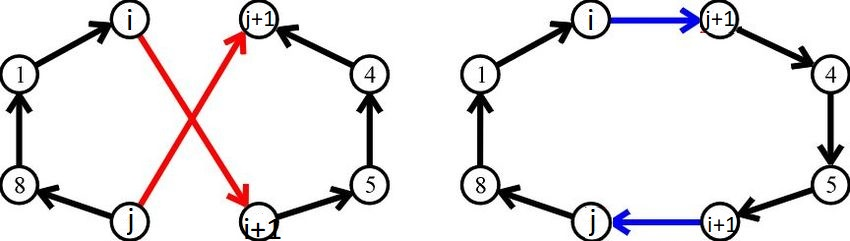
la fonction echange les position de deux element dans une routes par 2-opt (voir rapport de stage 2-opt)

cela signifie que le dépot peut-etre partie des element echanger : c'est pour cette raison que la recherche commence par i = -1 si le dépot joue le role de i dans la figure, est j fini par j+1 = len(route) si le depot joue le role de j+1.

Swap est une fonction utiliser par two-opt pour echanger deux elemnts par leurs position dans la route.

à chaque echange la fonction refait le meme processus.!!!!!!!!!!!!!!!!!!!

(il faut peut-etre ne pas faire cela : Hemmelmayr ne le fait pas) *Moves are performed in a first-improvement manner as long as an improvement can be found.*

In [ ]:
def swap(route,client1_position,client2_position):
  if client2_position == client1_position + 1:
      new_route = route[:]
      client1 = new_route[client1_position]
      client2 = new_route[client2_position]
      new_route[client1_position] = client2
      new_route[client2_position] = client1
      return new_route

  route_reversed = route[client1_position+1:client2_position+1]
  route_reversed.reverse()

  new_route = route[:client1_position+1]

  if client2_position+1 == len(route):
    new_route = new_route + route_reversed
  else:
    new_route = new_route + route_reversed + route[client2_position+1:]
  return new_route

def two_opt(route,distances,depot):
  changement = 1
  while changement == 1:
    changement = 0


    for i in range(-1,len(route)-1):
      for j in range(i+1,len(route)):

          if i==-1:
            pointI = depot
          else:
            pointI = route[i]
          if j+1 == len(route):
            pointJplus1 = depot
          else :
            pointJplus1 = route[j+1]
          pointIplus1 = route[i+1]
          pointJ = route[j]

          distance1 = distances[pointI][pointIplus1] + distances[pointJ][pointJplus1]
          distance2 = distances[pointI][pointJ] + distances[pointIplus1][pointJplus1]
          if distance1 > distance2:
            route = swap(route,i,j)
            changement = 1

  return route

**proximity_removal**


la fonction un nombre n de client de la meme region ou classe,
entre : objectLRP, classe qui represente des region

In [ ]:
def proximity_removal(problem,clusters,n=1):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    destroyed = problem
    solution = destroyed.solution
    i = random.randint(0,len(clusters)-1)
    if len(clusters[i]) < n:
      n = len(clusters[i])
    clients_deleted = selecte_random_client(clusters[i],n)
    destroyed.solution = supprimer_elements(destroyed.solution,clients_deleted)
    problem.unassigned_client = clients_deleted
    return destroyed,clients_deleted

**close_depot**

comme decrit par Hemmelmayr la fonction supprime un dépot, le met dans unassigned_depot, puis enleve les client associé à ce dépot et les mets dans unassigned client.

il choisi par suite un dépot à ouvrir, parmi les dépot ouverts et les non ouvert à part celui fermé par l'operateur,
s'il le dépot choisi est déja ouvert il ne fait rien

sinon il rajoute le dépot à la solution et lui associé un nombre (number_of_vehicule) de routes.

In [ ]:
def close_depot(problem,number_of_vehicle):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    solution = problem.solution
    clients_deleted = problem.unassigned_client
    unassigned_depot = problem.unassigned_depot


    i = random.randint(0,len(solution)-1)
    depot_and_routes = solution[i]
    depot = solution[i][0]
    print(solution[i])

    for routes_position in range(1,len(solution[i])):
      for client_positions in range(len(solution[i][routes_position])):
        if solution[i][routes_position] != []:
          problem.unassigned_client.append(depot_and_routes[routes_position][client_positions])
    problem.unassigned_depot.append(depot)

    solution.pop(i)

    depot2openList = [x for x in problem.depot_index if x !=  depot]
    print(problem.depot_index)
    depot2open = random.choice(depot2openList)
    openedDepot = [d[0] for d in solution]

    if depot2open not in openedDepot :
      liste = [depot2open]
      for i in range(number_of_vehicle):
        liste.append([])
      solution.append(liste)
      print(solution)
      print(depot2open)
      print(openedDepot)
      print(unassigned_depot)
      problem.unassigned_depot.remove(depot2open)




    return problem,clients_deleted,unassigned_depot


**select**

en entré la fonction reçoit un dictionnaire de nom des operateur et leur score,
et elle selectionne un operateur par la méthode Roulette wheel en transformant le score en proba

In [ ]:
def select(scoreDL):
  # Calculer les probabilités de sélection en inversant les scores (plus grand est le score, plus petite est la probabilité)
  total_score = sum(scoreDL.values())
  probabilites = {destructeur: score / total_score for destructeur, score in scoreDL.items()}

  # Sélectionner un destructeur avec l'opération "roulette wheel"
  destructeur_selectionne = random.choices(list(scoreDL.keys()), weights=list(probabilites.values()))[0]

  return destructeur_selectionne


**swap_depot**

ferme un dépot "df" comme close depot et choisi un à ouvrir, sauf que le choix est inversement proportionnel à la distance par rapport au dépot fermé.
la proba d'ouvrir un dépot j est :

pj = 1/di x 1/sum(1/distances des dépots par rapport au dépot fermé)

*voir le rapport de stage : swap depot*

le choix est fait par la méthode Roulette wheel

```
depot2open = random.choices(depot2openList, probabilities)[0]
```

In [ ]:
def swap_depot(problem,number_of_vehicle ):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    solution = problem.solution
    clients_deleted = problem.unassigned_client
    unassigned_depot = problem.unassigned_depot


    i = random.randint(0,len(solution)-1)
    depot_and_routes = solution[i]
    depot = solution[i][0]
    print(solution[i])

    for routes_position in range(1,len(solution[i])):
      for client_positions in range(len(solution[i][routes_position])):
        if solution[i][routes_position] != []:
          problem.unassigned_client.append(depot_and_routes[routes_position][client_positions])
    problem.unassigned_depot.append(depot)
    solution.pop(i)

    depot2openList = [x for x in problem.depot_index if x !=  depot]
    #___proba de choix de dépot est inversement proportionnel à la distance entre depot et depot ferme

    distanceDepot = [problem.distances[depot][i] for i in depot2openList]

    inverse_distances = [1/distance for distance in distanceDepot]

    total_inverse_distances = sum(inverse_distances)

    probabilities = [inverse_distance / total_inverse_distances for inverse_distance in inverse_distances]

    depot2open = random.choices(depot2openList, probabilities)[0]

    print("swap")
    print([depot,depot2openList])
    print(probabilities)






    openedDepot = [d[0] for d in solution] #depot déja ouverts

    if depot2open not in openedDepot :
      liste = [depot2open]
      for i in range(number_of_vehicle):
        liste.append([])
      solution.append(liste)
      print(solution)
      print(depot2open)
      print(openedDepot)
      print(unassigned_depot)
      problem.unassigned_depot.remove(depot2open)



    return problem,clients_deleted,unassigned_depot

**open_depot**
il choisi un dépot parmi les dépots fermé (unassigned_client),

il l'ouvre et supprime les un nombre (nombre_destruction) de client proche du dépot pour les inserer.


pour chosir des clients proche à inserer nous avons de chosir des client aléatoire de la meme region que le dépot.
```
    for i, sous_liste in enumerate(classification):
      if depot_and_route[0] in sous_liste:
        indice_sous_liste = i
        break
```
dans la partie initialisation de programme, classification est la matrice des regions des points (client et dépot) alors que clusters contient uniquement les clients.

dans la solution nous associons à ce dépot un nombre de route number_of_vehicule


In [ ]:
def open_depot(problem,nombre_destruction,number_of_vehicle,classification ,clusters ):
    """
    Removes a number of randomly selected customers from the passed-in solution.
    """
    depot_and_route = [problem.unassigned_depot[0]]
    for i in range(number_of_vehicle):
      depot_and_route.append([])
    problem.solution.append(depot_and_route)
    problem.unassigned_depot.remove(problem.unassigned_depot[0])


    for i, sous_liste in enumerate(classification):
      if depot_and_route[0] in sous_liste:
        indice_sous_liste = i
        break

    if len(clusters[indice_sous_liste]) < nombre_destruction:
      nombre_destruction = len(clusters[indice_sous_liste])
    clients_deleted = selecte_random_client(clusters[indice_sous_liste],nombre_destruction)
    problem.solution = supprimer_elements(problem.solution,clients_deleted)
    problem.unassigned_client = clients_deleted
    print(problem.unassigned_client)

    return problem,clients_deleted

**vehicle_capacity_violation**

cette fonction verifie si la capacité de vehicule n'est pas respecté.

il calcule les nombre de client dans chaque route, si ce nombre dépasse la capacité max, la fonction retourne 1

**number_of_vehicule_violation**

la fonction verifie si la contrainte de nombre de vehicule n'est pas respecté
il calcule le nombre de route qu'ils ont au moins un clients, si ce nombre dépasse les nombre de vehicule max, la fonction retourne 1

**weight_updates**

cette mis à jour les poids lié à chaque violation, nous verifiant si la contrainte n'est pas respecter par les deux fonction precedente, si c'est le cas,
la fonction multiplie le poids ancienne par sigma
si non, le poids se divise par sigma, tout en respectant l'interval possible des poids

In [ ]:
def vehicle_capacity_violation(problem,capacity_per_vehicule):

  #if solution violet constrained return 1
  solution = problem.solution
  for i in range(len(solution)):
    for j in range(1,len(solution[i])):
      if len(solution[i][j]) > capacity_per_vehicule :
        return 1
  return 0

def number_of_vehicule_violation(problem,number_of_vehicule):
  solution = problem.solution
  for i in range(len(solution)):
    s = 0
    for j in range(1,len(solution[i])):
      if len(solution[i][j]) > 1:
        s = s + 1
      if s > number_of_vehicule:
        return 1
  return 0

def weight_updates(problem, old_weight_vehicle_cap,old_weight_number_of_vehicle,min_val,max_val,capacity_per_vehicule,number_of_vehicule,sigma):
  if (vehicle_capacity_violation(problem,capacity_per_vehicule) == 1 ) and old_weight_vehicle_cap * sigma <= max_val:
    weight_vehicle_cap = old_weight_vehicle_cap * sigma
  elif (vehicle_capacity_violation(problem,capacity_per_vehicule) == 0 ) and old_weight_vehicle_cap / sigma >= min_val :
    weight_vehicle_cap = old_weight_vehicle_cap / sigma
  else:
    weight_vehicle_cap = old_weight_vehicle_cap

  if (number_of_vehicule_violation(problem,number_of_vehicule) == 1 ) and old_weight_number_of_vehicle * sigma <= max_val:
    weight_number_of_vehicle = old_weight_number_of_vehicle * sigma
  elif (number_of_vehicule_violation(problem,number_of_vehicule) == 0 ) and old_weight_number_of_vehicle / sigma >= min_val :
    weight_number_of_vehicle = old_weight_number_of_vehicle / sigma
  else:
    weight_number_of_vehicle = old_weight_number_of_vehicle

  return weight_vehicle_cap,weight_number_of_vehicle

**generate_itinerary**
cette fonction reçoit un partie d'une solution est le retourne dans une liste pour ensuite facilité le calcul des distance.

ex d'entré :  [depot1, [client11, client12,client12], [client21, client22]]
sortie output = [depot1, client11, client12, client12, depot1 ,client21, client22, depot1]

**objective**
la fonction calcule le coût total d'une solution,

elle calcule le trajet total en utilisant la fnct genrate_itinearary + coûts des dépot ouvert,

puis rajoute le poids d'une contrainte s'il n'est pas respecté.

la ligne suivante :

```
  if with_violation == True :
```
n'a pas d'importance réel sauf pour minimiser le temps de calcul pour les fonction qu n'ont pas besoin des violation dans le calcul


In [ ]:
def generate_itinerary(lst):

    itinerary = [lst[0]]  # Ajoute le point de départ à l'itinéraire

    for item in lst[1:]:
        if isinstance(item, list):
            itinerary.extend(item)  # Ajoute les éléments du chemin à l'itinéraire
            itinerary.append(lst[0])  # Ajoute le point de départ à la fin de chaque chemin
        else:
            itinerary.append(item)

    return itinerary

def objective(problem,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot,with_violation = True):
  s = 0
  distances = problem.distances
  solution = problem.solution

  for subtour in solution:
      chemin = generate_itinerary(subtour)
      distances_subtour = [distances[chemin[i]][chemin[i+1]] for i in range(len(chemin)-1)]
      s += sum(distances_subtour)
  if with_violation == True :
    s = s + weight_vehicle_cap * vehicle_capacity_violation(problem,capacity_per_vehicule) + weight_number_of_vehicle * number_of_vehicule_violation(problem,number_of_vehicule)
  numberofDepot = 0
  for i in range(len(solution)):
    for j in range(1,len(solution[i])):
      if len(solution[i][j]) > 0 :
        numberofDepot += 1
        break
  s = s + numberofDepot * coutDepot

  return s

In [ ]:
def optimised_objective_add_client(solution,localions,i,j,k,client,initial_objective):
  if len(solution[i][j]) == 1:
    position_a = localions[solution[i][0]]
    position_b = localions[solution[i][j][0]]
    position_c = localions[client]
  elif k == 0 and len(solution[i][j]) > 0:
    position_a = localions[solution[i][0]]
    position_b = localions[solution[i][j][k+1]]
    position_c = localions[client]
  elif len(solution[i][j]) == 0 and k == 0:
    position_a = localions[solution[i][0]]
    position_b = localions[solution[i][0]]
    position_c = localions[client]

  elif k == len(solution[i][j]):
    position_a = localions[solution[i][j][k-1]]
    position_b = localions[solution[i][0]]
    position_c = localions[client]
  else:
    position_a = localions[solution[i][j][k-1]]
    position_b = localions[solution[i][j][k]]
    position_c = localions[client]


  ac = ((position_c[0]-position_a[0])**2 + (position_c[1]-position_a[1])**2)**0.5
  ab = ((position_b[0]-position_a[0])**2 + (position_b[1]-position_a[1])**2)**0.5
  cb = ((position_b[0]-position_c[0])**2 + (position_b[1]-position_c[1])**2)**0.5


  current_objective = initial_objective + ac + cb - ab

  return current_objective

def optimised_objective(solution,localions,i,j,k,initial_objective):
    if len(solution[i][j]) == 1:
      position_a = localions[solution[i][0]]
      position_b = localions[solution[i][0]]
      position_c = localions[solution[i][j][k]]
    elif k == 0 :
      position_a = localions[solution[i][0]]
      position_b = localions[solution[i][j][k+1]]
      position_c = localions[solution[i][j][k]]
    elif k == len(solution[i][j])-1:
      position_a = localions[solution[i][j][k-1]]
      position_b = localions[solution[i][0]]
      position_c = localions[solution[i][j][k]]
    else:
      position_a = localions[solution[i][j][k-1]]
      position_b = localions[solution[i][j][k+1]]
      position_c = localions[solution[i][j][k]]


    ac = ((position_c[0]-position_a[0])**2 + (position_c[1]-position_a[1])**2)**0.5
    ab = ((position_b[0]-position_a[0])**2 + (position_b[1]-position_a[1])**2)**0.5
    cb = ((position_b[0]-position_c[0])**2 + (position_b[1]-position_c[1])**2)**0.5

    return initial_objective + ab-ac-cb



***calculateMoveGain***

cette fonction calcule la distance economisé si on bouge un client d'une position à une autre.

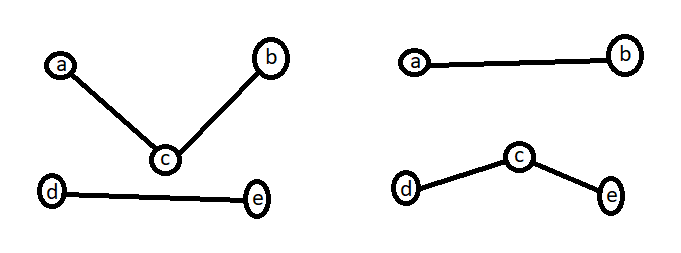

si la valeur est positive alors il faut déplacer le client

**local_search_1point_move_capacity**

cette fonction est une recherche locale qui ne considere que bouger les clients dans une route surchargée vers une autre souschargé

la fonction choisi le déplacement du client avec le gain le plus élévé.

si le poids lié à la capacité du vehicule est supérieur à 1000, le processus se repete 40 fois. pour forcer le respect de la contrainte dans le prochaines ittération.

In [ ]:

def calculateMoveGain(a,b,c,d,e,distances):
  ac = distances[a][c]
  cb = distances[c][b]
  de = distances[d][e]

  ab = distances[a][b]
  dc = distances[d][c]
  ce = distances[c][e]

  string1 = ac + cb + de
  string2 = ab + dc + ce
  return string1 - string2
def local_search_1point_move_capacity(solution_repaired_prime,capacity_per_vehicule,weight_vehicle_cap):
    distances = solution_repaired_prime.distances
    for i in range(len(solution_repaired_prime.solution)):
      for j in range(1,len(solution_repaired_prime.solution[i])):
        if len(solution_repaired_prime.solution[i][j]) > capacity_per_vehicule:
          COMP = 1
          if weight_vehicle_cap > 1000:
            COMP = 40
          for comp in range(COMP):
            gains = []
            for k in range(len(solution_repaired_prime.solution[i][j])):
              c = solution_repaired_prime.solution[i][j][k]

              if k-1 == -1:
                a = solution_repaired_prime.solution[i][0]
              else:
                a = solution_repaired_prime.solution[i][j][k-1]

              if k+1 == len(solution_repaired_prime.solution[i][j]):
                b = solution_repaired_prime.solution[i][0]
              else:
                b = solution_repaired_prime.solution[i][j][k+1]

              for q in range(len(solution_repaired_prime.solution)):
                for t in range(1,len(solution_repaired_prime.solution[q])):
                    if len(solution_repaired_prime.solution[q][t]) < capacity_per_vehicule :
                      for p in range(len(solution_repaired_prime.solution[q][t])+1):
                        if p-1==-1:
                          d = solution_repaired_prime.solution[q][0]
                        else:
                          d = solution_repaired_prime.solution[q][t][p-1]

                        if p==len(solution_repaired_prime.solution[q][t]):
                          e = solution_repaired_prime.solution[q][0]
                        else:
                          e = solution_repaired_prime.solution[q][t][p]
                        gain = calculateMoveGain(a,b,c,d,e,distances) + weight_vehicle_cap
                        gains.append((gain,i,j,k,q,t,p,c))

            max_gains = max(gains) #plus c'est grands plus c'est interessant de deplacer
            if max_gains[0] <= 0:
              continue

            else:
              #indices
              """
              l = old_depot_index
              m = old_route_index
              n = old_client_index
              d = new_depot
              o = new_route_index
              p = new_client_index
              """
              _,l,m,n,d,o,p,client2insert = max_gains
              del solution_repaired_prime.solution[l][m][n]
              solution_repaired_prime.solution = add_client(solution_repaired_prime.solution,d, o, p, client2insert)

    return solution_repaired_prime



**local_search_1point_move**

c'est la recherche locale qui bouge le client dans les positions les plus optimale que ce soit une position qui ne respecte pas la contrainte de position ou non.

gains est une liste d'element : (gain, position initial i,j,k, nouvelle position q,t,p, est client concerné c)

la fonction insere chaque client dans la position avec le gain le plus elevé.

In [ ]:
def local_search_1point_move(solution_repaired_prime,capacity_per_vehicule,weight_vehicle_cap):
    distances = solution_repaired_prime.distances
    for i in range(len(solution_repaired_prime.solution)):
      for j in range(1,len(solution_repaired_prime.solution[i])):
            gains = []
            for k in range(len(solution_repaired_prime.solution[i][j])):
              c = solution_repaired_prime.solution[i][j][k]

              if k-1 == -1:
                a = solution_repaired_prime.solution[i][0]
              else:
                a = solution_repaired_prime.solution[i][j][k-1]

              if k+1 == len(solution_repaired_prime.solution[i][j]):
                b = solution_repaired_prime.solution[i][0]
              else:
                b = solution_repaired_prime.solution[i][j][k+1]

              for q in range(len(solution_repaired_prime.solution)):
                for t in range(1,len(solution_repaired_prime.solution[q])):
                      for p in range(len(solution_repaired_prime.solution[q][t])+1):
                        if p-1==-1:
                          d = solution_repaired_prime.solution[q][0]
                        else:
                          d = solution_repaired_prime.solution[q][t][p-1]

                        if p==len(solution_repaired_prime.solution[q][t]):
                          e = solution_repaired_prime.solution[q][0]
                        else:
                          e = solution_repaired_prime.solution[q][t][p]
                        gain = calculateMoveGain(a,b,c,d,e,distances)
                        if len(solution_repaired_prime.solution[q][t]) > capacity_per_vehicule and len(solution_repaired_prime.solution[q][t]) < capacity_per_vehicule:
                          gain = gain + weight_vehicle_cap
                        gains.append((gain,i,j,k,q,t,p,c))

            if gains == []:
              continue
            else:

              max_gains = max(gains) #plus c'est grands plus c'est interessant de deplacer
              if max_gains[0] <= 0:
                continue

              else:
                #indices
                """
                l = old_depot_index
                m = old_route_index
                n = old_client_index
                d = new_depot
                o = new_route_index
                p = new_client_index
                """
                _,l,m,n,d,o,p,client2insert = max_gains
                del solution_repaired_prime.solution[l][m][n]
                solution_repaired_prime.solution = add_client(solution_repaired_prime.solution,d, o, p, client2insert)

    return solution_repaired_prime

**local_search_2opt**

la fonction prend chaque route est applique le 2-opt mentionné ci-dessus

elle utilise two-opt pour chaque route sauf si la route n'a pas de client

In [ ]:
def local_search_2opt(solution_repaired_prime):
    for l in range(len(solution_repaired_prime.solution)):
      for m in range(1,len(solution_repaired_prime.solution[l])):
        if len(solution_repaired_prime.solution[l][m]) != 0:
          ROUTEi = l
          ROUTEj = m
          depot = solution_repaired_prime.solution[ROUTEi][0]
          solution_repaired_prime.solution[ROUTEi][ROUTEj] = two_opt(solution_repaired_prime.solution[ROUTEi][ROUTEj],solution_repaired_prime.distances,depot)
    return solution_repaired_prime


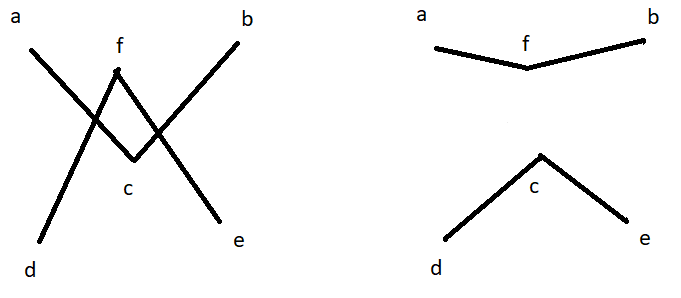

**exgange2point**
cette fonction echange l'emplacement de deux client si cela donne un gain (calculé par la fonction calculateSwapGain)

elle ne prend pas le poids des violation en considération

In [ ]:
def calculateSwapGain(a,b,c,d,e,f,distances):
  acb = distances[a][c]+distances[c][b]
  dfe = distances[d][f]+distances[f][e]

  afb = distances[a][f]+distances[f][b]
  dce = distances[d][c]+distances[c][e]

  string1 = acb+ dfe
  string2 = afb + dce

  #if string1 - string2 > 0 alors il faut echanger
  return string1 - string2





def exgange2point(solution_repaired_prime):

    distances = solution_repaired_prime.distances
    change = 1
    while change == 1:
      change = 0
      for i in range(len(solution_repaired_prime.solution)):
        for j in range(1,len(solution_repaired_prime.solution[i])):
          if len(solution_repaired_prime.solution[i][j]) >= 1:
            for k in range(len(solution_repaired_prime.solution[i][j])):

              for l in range(len(solution_repaired_prime.solution)):
                for m in range(1,len(solution_repaired_prime.solution[l])):
                  if len(solution_repaired_prime.solution[l][m]) >= 1:
                    for n in range(len(solution_repaired_prime.solution[l][m])):
                      if l != i and m != j:
                        c = solution_repaired_prime.solution[i][j][k]
                        if k-1 == -1:
                          a = solution_repaired_prime.solution[i][0]
                        else:
                          a = solution_repaired_prime.solution[i][j][k-1]

                        if k+1 == len(solution_repaired_prime.solution[i][j]):
                          b = solution_repaired_prime.solution[i][0]
                        else:
                          b = solution_repaired_prime.solution[i][j][k+1]
                        f = solution_repaired_prime.solution[l][m][n]
                        if n-1==-1:
                          d = solution_repaired_prime.solution[l][0]
                        else:
                          d = solution_repaired_prime.solution[l][m][n-1]

                        if n+1==len(solution_repaired_prime.solution[l][m]):
                          e = solution_repaired_prime.solution[l][0]
                        else:
                          e = solution_repaired_prime.solution[l][m][n+1]

                        if calculateSwapGain(a,b,c,d,e,f,distances) > 0:
                          solution_repaired_prime.solution[i][j][k] = f
                          solution_repaired_prime.solution[l][m][n] = c
                          change = 1


    return solution_repaired_prime

#initiialisation du problème

dans cette partie nous allons mettre la solution initial de chaque problème.
les solution initial comme indiqué dans le rapport, sont composé par des route unique pour chaque client.

pour selectionner un problèmeil faut taper le nom de la ville parmi sur https://github.com/ahf0/inrae_stage/tree/main/cities

remarque : pour rajouter un problem il faut modifier le lien dans la classe LRP, le GitHub est capable convertir les données du texte de str vers bytes, ce qui est nécessaire pour la couche manipulation.

il faut ensuite selectionné une solution initial sous la forme :

```
solution_ville06 = [[depot1, [rout11], [route12]], [depot2, [route21], [route22], [route23]]]
```
il faut choisir quel type de classification soit le K-mean ou DbScan

```
#classification = dbscan_clustering(vrp.locations, epsilon, min_samples)
locations2clusters = copy.deepcopy(vrp.locations)
classification = Kmean_clustering(locations2clusters,5)
```

enlevez le commentaire pour le dbscan (mais à chaque problème il faut un autre parametre epsilon et min_sample)







In [ ]:
# create a problem instance:
solution_ville01 = [[2, [3,5,6],[7,10],[]]
                    ,[4,[1, 8,0], [ 9,11]]]


solution_ville02 = [[5, [1,2,14,0,15],[12,6,7,16],[]]
                    ,[13,[10,4,3,8],[17,18,9], [11]]]

solution_ville03 = [[12,[],[0,1,2,21,22,23,3,4],[],[]],[14,[10,24,25,30,26,11,13],[5,6,7,8,9,18,19,20],[27,28,29,17,15,16]]]
solution_ville03 = [[12,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[13],[15],[16],[17],[18],[19],[20]]
                    ,[14,[21],[22],[23],[24],[25],[26],[27],[28],[29],[30]]]

#solution_ville04 = [[12, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25], [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39],[]],[50, [14, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60], [40, 41, 42, 43, 44, 45, 46, 47, 48, 49], []]]
solution_ville04 = [[12,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[13],[14],[15],[16],[17],[18],[19],[20],[21],[22],[23],[24],[25],[26],[27],[28],[29],[30]]
                    ,[50,[26],[27],[28],[29],[30],[31],[32],[33],[34],[35],[36],[37],[38],[39],[40],[41],[42],[43],[44],[45],[46],[47],[48],[49],[51],[52],[53],[54],[55],[56],[57],[58],[59],[60]]]




solution_ville05 = [[1, [79, 5, 44, 198, 152, 76, 89, 30, 12, 14, 132, 20, 11, 23, 178, 25, 6, 16]]
                    , [117,[175, 26, 32, 33, 115, 157, 43, 10, 197, 22, 39, 87, 78, 15, 73, 195, 21, 167, 142, 58, 138, 18, 42, 130, 46, 47], [50, 24, 193, 57, 61, 62, 38, 158, 108, 143, 63, 35, 69, 29, 104, 68, 71, 101]],[ 72,[ 91, 49, 64, 54, 36, 75, 4, 173, 154, 51, 146, 172, 59, 156, 55, 83, 3, 53, 188, 184, 88, 191, 86, 90, 70, 7, 139, 131, 93, 95], [187, 19, 136, 121, 181, 77, 67, 2, 41, 174, 170]]
                    , [100, [92, 185, 102, 9, 111, 98, 109, 107, 163, 110]]
                    , [40,[ 155, 112, 113, 114, 140, 151, 66, 118, 120, 122, 123, 196, 171, 85, 128, 94, 125, 126, 127, 129, 74, 133, 134, 135, 60, 144, 148, 124, 145, 147], [97, 48, 0, 65, 150, 99, 161, 186, 82, 164, 183, 168, 166, 105, 137, 176, 159, 179, 180, 165, 28, 182, 119, 160, 52, 31, 192, 190, 189, 177, 153, 103, 116, 13, 199], [96, 106, 194, 56, 149, 17, 27, 200, 8, 80, 81, 37, 84, 45, 141, 34, 162, 169]]]
solution_ville05 = [[1,[0], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [41], [42], [43], [44], [45], [46], [47], [48], [49]]
                    ,[40,[50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99]]
                    ,[100, [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149]]
                    ,[117,[150], [151], [152], [153], [154], [155], [156], [157], [158], [159], [160], [161], [162], [163], [164], [165], [166], [167], [168], [169], [170], [171], [172], [173], [174], [175], [176], [177], [178], [179], [180], [181], [182], [183], [184], [185], [186], [187], [188], [189], [190], [191], [192], [193], [194], [195], [196], [197], [198], [199],[200]]]
#solution_ville05 = [[1, [62, 5, 114, 198, 13, 136, 152, 41, 57, 11, 76, 162, 20, 132, 83, 63, 50, 4, 112, 115, 172, 33, 91, 38, 65, 142, 78, 88, 15, 24, 21, 151, 3, 188, 138, 145, 167, 7, 51, 35], [64, 89, 10, 184, 28, 12, 30, 147, 133, 113, 118, 143, 71, 135, 146, 158, 165, 168, 49, 36, 148, 166, 156, 94, 125, 55, 40, 197, 53, 43, 18, 191, 108, 48, 99, 196, 90, 67, 25, 131, 92, 93], [60, 181, 2, 117, 174, 170, 192, 144],[],[]]
#                    , [100, [75, 66, 109, 134, 29, 178, 102, 9, 123, 39, 79, 107, 37, 163, 195, 42, 73, 155, 128, 58, 140, 69, 179, 46, 120, 122, 86, 0, 72, 139, 22, 185, 171, 154, 173, 6, 70, 124, 80, 160, 127, 103, 52, 177, 54, 95, 82, 34, 87, 61, 59, 175], [27, 23, 97, 111, 187, 119, 68, 98, 104, 186, 121, 164, 47, 150, 110, 183, 130, 137, 159, 161, 105, 182, 44, 180, 101, 74, 31, 189, 190, 14, 116, 19, 193, 77, 199, 85, 16], [149, 96, 153, 26, 32, 129, 126, 17, 141, 45, 56, 200, 194, 106, 8, 81, 157, 84, 176, 169],[],[]]]

solution_ville06 = [[20, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
                     ,[26, 27, 28, 29, 30, 31, 32, 33, 34],[]]
                    ,[25,[50, 51, 52, 54, 55, 56, 57, 85, 86]
                      , [75, 76, 77, 78, 79, 80, 81, 82, 83, 84],[]]
                    ,[53,[87, 88, 89, 90, 91, 92, 93, 94, 35]
                      ,[22, 23, 24,95, 96, 97, 98, 99, 10, 11, 12, 13]]
                    ,[43,[64, 65, 66, 67, 68, 69, 70, 71, 72]
                      ,[18, 19, 21, 59, 60, 61, 62, 63, 73, 74]]
                    ,[58,[38, 39, 40, 41, 42, 44, 45, 46]
                      ,[14, 15, 16, 17,47, 48, 49, 36, 37]]]
solution_ville06 = [[20,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[21],[22],[23],[24],[26],[27],[28],[29],[30]]
                    ,[25,[31],[32],[33],[34],[35],[36],[37],[38],[39],[40],[41],[42],[44],[45],[46],[47],[48],[49],[50],[51],[52],[54],[55],[56],[57],[59],[60]]
                    ,[53,[61],[62],[63],[64],[65],[66],[67],[68],[69],[70]]
                    ,[43,[71],[72],[73],[74],[75],[76],[77],[78],[79],[80]]
                    ,[58,[81],[82],[83],[84],[85],[86],[87],[88],[89],[90],[91],[92],[93],[94],[95],[96],[97],[98],[99]]]

solution_ville08 = [[0,[10],[11],[12],[13],[14],[15],[16],[17],[18],[19],[20],[21],[22],[23],[24]]
                    ,[1,[25],[26],[27],[28],[29],[30],[31],[32],[33],[34],[35],[36],[37],[38],[39],[40],[41],[42]]
                    ,[2,[43],[44],[45],[46],[47],[48],[49],[50],[51],[52],[53],[54],[55],[56]]
                    ,[3,[57],[58],[59],[60],[61],[62],[63],[64],[65],[66],[67],[68],[69],[70]]
                    ,[4,[71],[72],[73],[74],[75]]
                    ,[5,[76],[77],[78],[79],[80]]
                    ,[6,[81],[82],[83],[84]]
                    ,[7,[85],[86],[87],[88],[89],[90]]
                    ,[8,[91],[92],[93],[94],[95],[96],[97],[98],[99]]
                    ,[9,[100],[101],[102],[103],[104],[105],[106],[107],[108],[109]]]

solution_ville09 = [[42,[0],[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]]
                    ,[68,[11],[13],[14],[15],[16],[17],[20]]
                    ,[12,[21],[22],[23],[24],[25],[26],[28],[29],[30],[31]]
                    ,[18,[32],[33],[34],[35],[36],[37],[38],[39],[41]]
                    ,[66,[43],[44],[45],[46],[47],[48],[49],[50],[51]]
                    ,[90,[52],[53],[54],[56],[57],[58],[59],[60],[61]]
                    ,[27,[62],[63],[64],[65],[67],[69],[70]]
                    ,[40,[71],[72],[74],[75],[76],[77],[78],[79],[80],[81],[82]]
                    ,[83,[84],[85],[86],[87],[88],[89]]
                    ,[19,[91],[92],[93],[94]]
                    ,[55,[95],[96],[97]]
                    ,[73,[98],[99]]]


nom_de_ville = "ville04" #ville08 est instances 111112 sur http://prodhonc.free.fr/Instances/instances_us.htm

vrp = lrp.LocationRoutingProblem(nom_de_ville, None,solution_ville04)



epsilon = 7
min_samples = 4

#classification = dbscan_clustering(vrp.locations, epsilon, min_samples)
locations2clusters = copy.deepcopy(vrp.locations)
classification = Kmean_clustering(locations2clusters,5)
clusters = copy.deepcopy(classification)
for i in range(len(clusters)):
    j = len(clusters[i]) - 1
    while j >= 0:
        if clusters[i][j] in vrp.depot_index:
            del clusters[i][j]
        j -= 1
print(clusters)
print(classification)


[[1, 8, 21, 24, 30, 33, 34, 40, 44, 46, 49, 53, 59], [5, 6, 10, 14, 17, 20, 22, 26, 27, 31, 36, 43, 47, 48, 52, 57], [7, 15, 28, 32, 37, 38, 41, 54, 60], [2, 3, 11, 13, 16, 18, 19, 23, 35, 45, 58], [0, 4, 9, 25, 29, 39, 42, 51, 55, 56]]
[[1, 8, 12, 21, 24, 30, 33, 34, 40, 44, 46, 49, 50, 53, 59], [5, 6, 10, 14, 17, 20, 22, 26, 27, 31, 36, 43, 47, 48, 52, 57], [7, 15, 28, 32, 37, 38, 41, 54, 60], [2, 3, 11, 13, 16, 18, 19, 23, 35, 45, 58], [0, 4, 9, 25, 29, 39, 42, 51, 55, 56]]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
#objective(problem,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,with_violation = True):
random.seed(42)
solution = copy.deepcopy(vrp)
distance = []
distance_min = []
distance_min_no_violation = []
solutions = []
solutions_min = [vrp.solution]
# generate random solution and evaluate it:
nombre_iterations = 5000
weight_vehicle_cap = 10
weight_number_of_vehicle = 10
sigma = 1.1

#_____________Contrainte____________________
# il faut que  capacity_per_vehicule * number_of_vehicule * nombre de depots > nombre de clients
capacity_per_vehicule = 30
number_of_vehicule = 4

#________cout de fixation d'un depot________
coutDepot = np.mean(vrp.distances)/4

objective_minimal = objective(vrp,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot)
distance_min = [objective_minimal]
distance = [objective_minimal]
distance_min_no_violation = [objective_minimal]

seuil = objective_minimal
solution_optimale = vrp.copy()
nombre_de_points = vrp.lrpSize
alpha = 0.2 #coef d'acceptance
compteur = 0
regret_num = 5
weights_vehicle_cap = []
weights_number_of_vehicle = []
min_val = np.mean(vrp.distances) / 5
max_val = np.mean(vrp.distances) * 300
vehicule_number = capacity_per_vehicule + 4 # c'est un nombre de route dans un dépôt à explorer cela devra etre plus grand que la nombre de vehicule par dépôt

#______score_____________
scoreDL = {
    "close_depot": 100,
    "open_depot": 100,
    "swap_depot":100
}
scoreDS = {
    "worst_removal_aleatoire": 100,
    "proximity_removal": 100,
    "random_removal":100,
}
scoreR = {
    "regret_repair": 100,
    "greedy_repair_optimised_perturbation": 100,
}

probaDL = copy.deepcopy(scoreDL)
probaDS = copy.deepcopy(scoreDS)
probaR = copy.deepcopy(scoreR)

close_depot_scores = []
open_depot_scores = []
swap_depot_scores = []

worst_removal_aleatoire_scores = []
proximity_removal_scores = []
random_removal_scores = []

regret_repair_scores = []
greedy_repair_optimised_perturbation_scores = []


updateScore1 = False
updateScore2 = False
updateScore3 = False

w = 120

nu = 30

comp_update_proba = 0

for i in range(nombre_iterations):
  print("etape : {}".format(i))

  #_______________Destructor LARGE_____________
  if compteur == w:

    n_min = int(nombre_de_points*0.2)
    n_max = int(nombre_de_points*0.25)
    nombre_destruction = random.randint( n_min, n_max)

    print("_____________destruction N___________")

    Dname = select(probaDL)

    if Dname  == "open_depot" and len(solution.unassigned_depot) > 0:
      solution_destroyed,client_deleted2 = open_depot(solution,nombre_destruction,vehicule_number,classification , clusters)
    elif Dname == "swap_depot":
      solution_destroyed,client_deleted2,unassigned_depot2 = swap_depot(solution,vehicule_number)
    else:
      solution_destroyed,client_deleted2,unassigned_depot2 = close_depot(solution,vehicule_number)
      Dname = "close_depot"

  #____________________________________________


  #___________Destructor SMALL________________
  else :
    n_min = int(nombre_de_points*0.006)
    n_max = int(nombre_de_points*0.1)
    nombre_destruction = random.randint( n_min, n_max)

    if nombre_destruction == 0:
      nombre_destruction = 1

    Dname = select(probaDS)
    if Dname == "worst_removal_aleatoire":
      solution_destroyed,client_deleted2 = worst_removal_aleatoire(solution,nombre_destruction)
    if Dname == "proximity_removal":
      solution_destroyed,client_deleted2 = proximity_removal(solution,clusters,nombre_destruction)
    if Dname == "random_removal":
      solution_destroyed,client_deleted2 = random_removal(solution,nombre_destruction)
  #___________________________________________


  #______________Repair_______________________
  Rname = select(probaR)
  if Rname == "regret_repair":
    solution_repaired_prime = regret_repair(solution_destroyed,regret_num)
  if Rname == "greedy_repair_optimised_perturbation":
    solution_repaired_prime = greedy_repair_optimised_perturbation(solution_destroyed)
  #____________________________________________



  #________________Free PASS__________________
  if compteur == 120:

    solution_repaired_prime = local_search_1point_move(solution_repaired_prime,capacity_per_vehicule,weight_vehicle_cap)
    solution_repaired_prime = local_search_2opt(solution_repaired_prime)
    solution_repaired_prime = local_search_1point_move_capacity(solution_repaired_prime,capacity_per_vehicule,weight_vehicle_cap)
    solution_repaired_prime = exgange2point(solution_repaired_prime)
    solution = copy.deepcopy(solution_repaired_prime)
    compteur = 0
  #___________________________________________



  #__________accepted solution VERIFY_________
  elif objective(solution_repaired_prime,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot) < objective(solution_optimale,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot)*(1+alpha):
    solution_repaired_prime = local_search_1point_move(solution_repaired_prime,capacity_per_vehicule,weight_vehicle_cap)
    solution_repaired_prime = local_search_2opt(solution_repaired_prime)
    solution_repaired_prime = local_search_1point_move_capacity(solution_repaired_prime,capacity_per_vehicule,weight_vehicle_cap)
    solution_repaired_prime = exgange2point(solution_repaired_prime)
    updateScore1 = True
  distance.append(objective(solution_repaired_prime,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot))
  #___________________________________________



  #_________better Solution___________________
  if objective(solution_repaired_prime,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot) < objective(solution,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot):
    solution = copy.deepcopy(solution_repaired_prime)
    compteur = 0
    updateScore2 = True
  else :
    compteur = compteur + 1
  #___________________________________________




  #________optimal Solution___________________
  if objective(solution,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot) < objective(solution_optimale,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot):
    solution_optimale = solution.copy()
    solutions.append(solution_optimale.solution.copy())
    objective_minimal = objective(solution_optimale,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot)
    solutions_min.append(solution_optimale.solution.copy())
    updateScore3 = True
    if objective_minimal < seuil and vehicle_capacity_violation(solution_optimale,capacity_per_vehicule) == 0 and number_of_vehicule_violation(solution_optimale,number_of_vehicule)== 0:
      result = copy.deepcopy(solution_optimale)
      seuil = objective_minimal
      etape_dernier = i
  #___________________________________________


  distance_min.append(objective(solution_optimale,weight_vehicle_cap,weight_number_of_vehicle,capacity_per_vehicule,number_of_vehicule,coutDepot))
  distance_min_no_violation.append(seuil)
  weights_vehicle_cap.append(weight_vehicle_cap)
  weights_number_of_vehicle.append(weight_number_of_vehicle)

  #___update weight____
  weight_vehicle_cap,weight_number_of_vehicle = weight_updates(solution_optimale,weight_vehicle_cap,weight_number_of_vehicle,  min_val,  max_val,capacity_per_vehicule,number_of_vehicule,sigma)

  #______________update score_________________

  if updateScore3 == True :
    updateScore3 = False
    if Dname in scoreDL:
      scoreDL[Dname] = scoreDL[Dname] + nu
    if Dname in scoreDS:
      scoreDS[Dname] = scoreDS[Dname] + nu

    scoreR[Rname] = scoreR[Rname] + nu

  elif updateScore2 == True:
    updateScore2 = False
    if Dname in scoreDL:
      scoreDL[Dname] = scoreDL[Dname] + nu/2
    if Dname in scoreDS:
      scoreDS[Dname] = scoreDS[Dname] + nu/2
    scoreR[Rname] = scoreR[Rname] + nu/2

  elif updateScore1 == True:
    updateScore1 = False
    if Dname in scoreDL:
      scoreDL[Dname] = scoreDL[Dname] + nu/3
    if Dname in scoreDS:
      scoreDS[Dname] = scoreDS[Dname] + nu/3
    scoreR[Rname] = scoreR[Rname] + nu/3

  comp_update_proba += 1
  if comp_update_proba == 100:
    probaDL = copy.deepcopy(scoreDL)
    probaDS = copy.deepcopy(scoreDS)
    probaR = copy.deepcopy(scoreR)
    comp_update_proba = 0
  #__________________________________________



  close_depot_scores.append(scoreDL["close_depot"])
  open_depot_scores.append(scoreDL["open_depot"])
  swap_depot_scores.append(scoreDL["swap_depot"])

  worst_removal_aleatoire_scores.append(scoreDS["worst_removal_aleatoire"])
  proximity_removal_scores.append(scoreDS["proximity_removal"])
  random_removal_scores.append(scoreDS["random_removal"])

  regret_repair_scores.append(scoreR["regret_repair"])
  greedy_repair_optimised_perturbation_scores.append(scoreR["greedy_repair_optimised_perturbation"])






Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
etape : 208
etape : 209
etape : 210
etape : 211
etape : 212
etape : 213
etape : 214
etape : 215
etape : 216
etape : 217
etape : 218
etape : 219
etape : 220
etape : 221
etape : 222
etape : 223
etape : 224
etape : 225
etape : 226
etape : 227
etape : 228
etape : 229
etape : 230
etape : 231
etape : 232
etape : 233
etape : 234
etape : 235
etape : 236
etape : 237
etape : 238
etape : 239
etape : 240
_____________destruction N___________
[50, [33, 49, 44, 30, 40, 1, 3, 23, 18, 16, 35, 45, 11, 39, 27, 36, 6, 10, 14, 48, 31, 26, 17, 22, 20, 46, 24, 34, 53], [], [], [], [], [], [21, 59, 13, 47, 57, 52, 5, 43, 4, 0, 29, 42, 56, 25, 55, 51, 9, 2, 58, 19, 32, 60, 41, 54, 38, 37, 7, 28, 15, 8], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]
[12, 50]
[[12, [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []

#Partie résultats
le taux ou pourcentage de diminution est fait en comparant le cout à l'itération 50 avec le coût final sans violation

dans cette partie et la partie précedente distances signifie coûts total

distance_min c'est le coût minimal incluant les violations (il peut augmenter avec le poids)

distance_min_no_violation c'est le coût total des solutions de coût minimal mais sans violation (ça peut arriver que le coût minimal avec violation soit plus petit que celui sans violation)
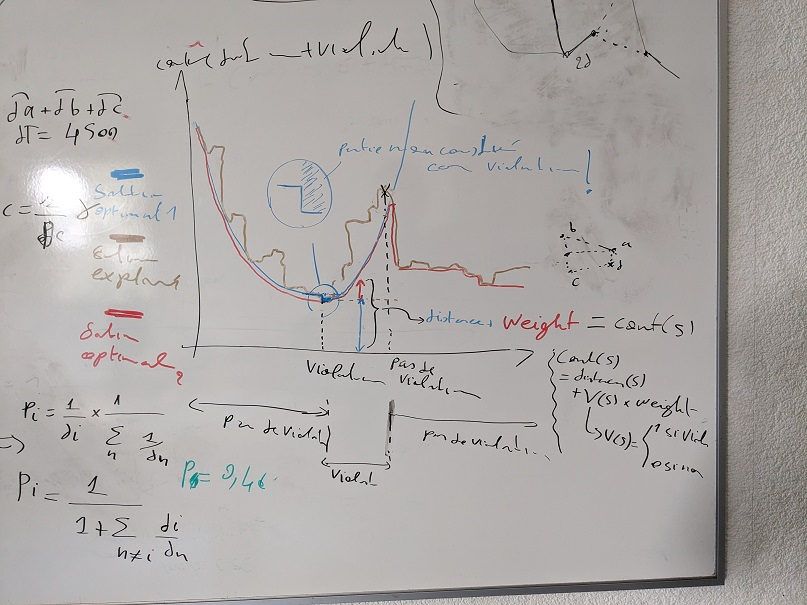

[[12, [0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30]], [50, [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60]]]
[[12, [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [8, 15, 28, 7, 37, 38, 54, 41, 60, 32, 19, 58, 2, 9, 51, 55, 25, 56, 42, 29, 0, 4, 39, 5, 52, 36, 57, 47, 1, 40], [59, 21, 49, 33, 44, 30, 53, 34, 24, 46, 20, 22, 17, 26, 31, 48, 14, 10, 6, 27, 43, 11, 13, 23, 45, 35, 16, 18, 3], [], []]]


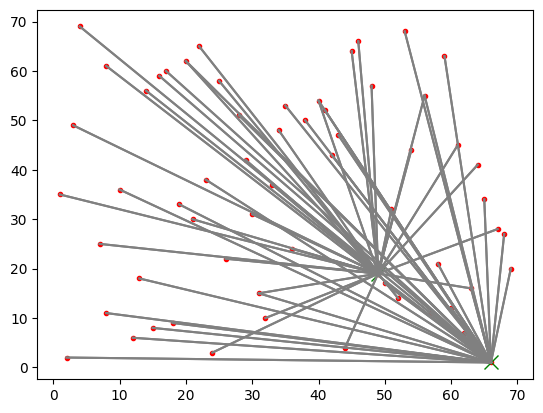

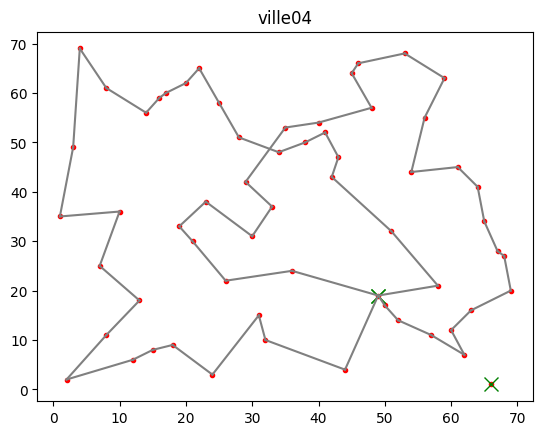

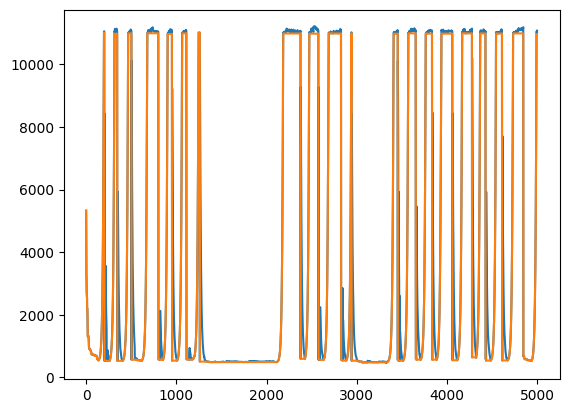

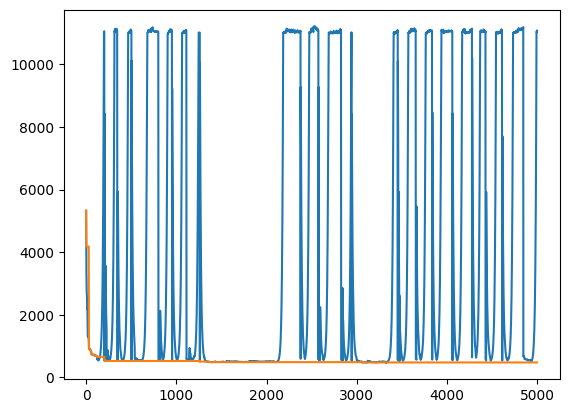

coût à l'itération 50: 864.6183760169372
coût totale : 478.5827957393341
porcentage de diminution : 44.648037157802605%
{'close_depot': 190, 'open_depot': 100, 'swap_depot': 160}
{'worst_removal_aleatoire': 20140.0, 'proximity_removal': 11430.0, 'random_removal': 16590.0}
{'regret_repair': 29250.0, 'greedy_repair_optimised_perturbation': 18960.0}
dernière itération 3059
cout d'un depot 9.05222356335446


In [ ]:
print(vrp.solution)
print(result.solution)
# plot the solution:

plot = vrp.plotData()
plot.show()
for i in vrp.depot_index:
    d = vrp.locations[i]
    plot.plot(d[0], d[1], marker='x', markersize=10, color='green')
plot = result.plotData()
plot.title(nom_de_ville)
plot.show()

plot.plot(distance)
plot.plot(distance_min)
plot.show()
plot.plot(distance)
plot.plot(distance_min_no_violation)
plot.show()
print("coût à l'itération 50: {}".format(distance_min_no_violation[50]))
print("coût totale : {}".format(distance_min_no_violation[-1]))
print("porcentage de diminution : {}%".format((distance_min_no_violation[50]-distance_min_no_violation[-1])/(0.001+distance_min_no_violation[50])*100))
print(scoreDL)
print(scoreDS)
print(scoreR)
print("dernière itération {}".format(etape_dernier))
print("cout d'un depot {}".format(coutDepot))

#variation de poids

cette courbe est importante pour verifier si les contraintes sont correcte,

si les deux courbe oscille inversement par rapport à l'un l'autre cela signifie que il faut augmenter la capacité ou, et le nombre de vehicule dans la partie inititalisation des résultats

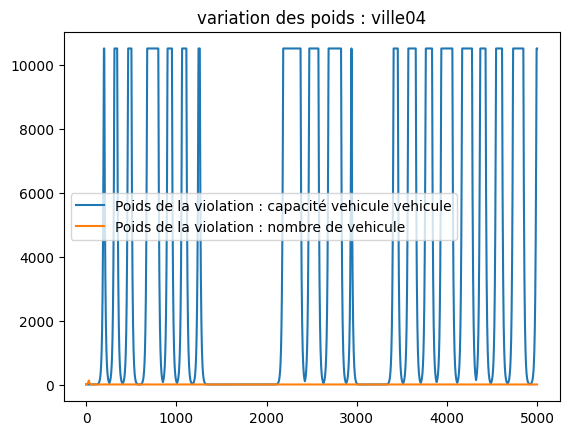

In [ ]:
plot.plot(weights_vehicle_cap[:])
plot.plot(weights_number_of_vehicle[:])
plot.legend(["Poids de la violation : capacité vehicule vehicule","Poids de la violation : nombre de vehicule"])
plot.title("variation des poids : {}".format(nom_de_ville))
plot.show()

cette partie montre la variation des trois courbes : courbe d'exploration (solution accepté s'), courbe de cout minimum mais avec poids au cas de violation s* et la courbe sans aucune violation s** (result)

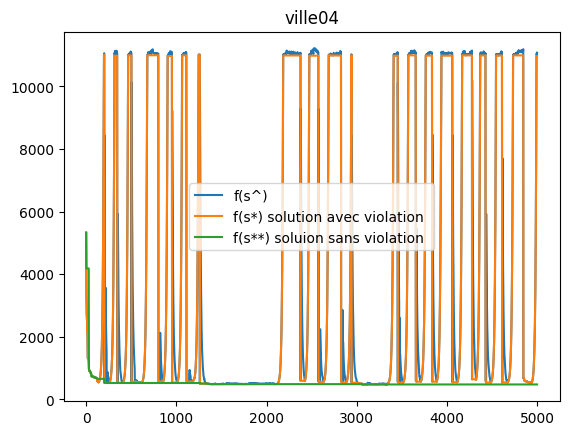

In [ ]:
plot.plot(distance[:])
plot.plot(distance_min[:])
plot.plot(distance_min_no_violation[:])
plot.legend(['f(s^)','f(s*) solution avec violation ','f(s**) soluion sans violation'])
plot.title(nom_de_ville)
plot.show()

pour faire de l'analyse, nous pourrions rajouter (True) à la méthode plot pour afficher les indices des points

la boucle est pour rajouter les x sur les dépot

478.5827957393341
3059


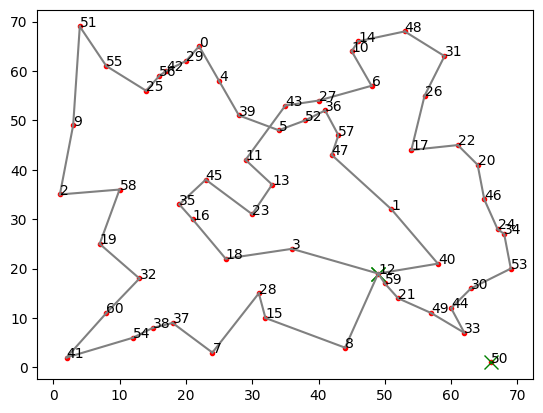

In [ ]:
print(objective(result,weight_vehicle_cap,weight_vehicle_cap,capacity_per_vehicule,number_of_vehicule,coutDepot))
print(etape_dernier)
for i in vrp.depot_index:
          d = vrp.locations[i]
          plot.plot(d[0], d[1], marker='x', markersize=10, color='green')
plot = result.plotData(True)
plot.show()

le score est différent de proba de selection.

la proba de selection est mis à jour à chaque comp_update_proba = 100, pour réduire la divergence des operateurs dès le départ.

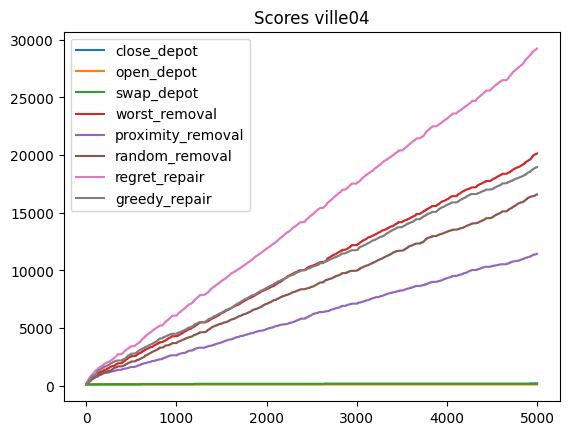

In [ ]:

plot.plot(close_depot_scores)
plot.plot(open_depot_scores)
plot.plot(swap_depot_scores)
plot.plot(worst_removal_aleatoire_scores)
plot.plot(proximity_removal_scores)
plot.plot(random_removal_scores)
plot.plot(regret_repair_scores)
plot.plot(greedy_repair_optimised_perturbation_scores)
plot.title("Scores {}".format(nom_de_ville))
plot.legend(["close_depot","open_depot","swap_depot","worst_removal","proximity_removal","random_removal","regret_repair","greedy_repair"])
plot.show()

Ici nous comparant la variation des scores selon l'objectif de chaque operateur

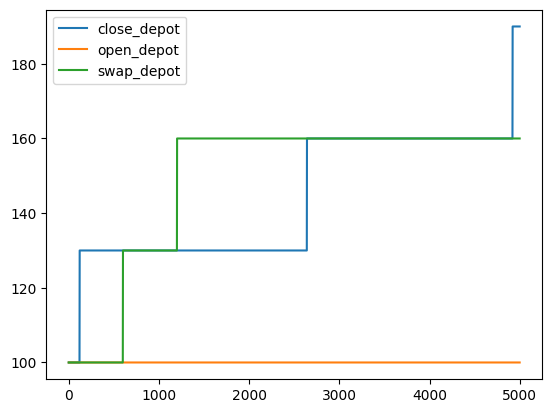

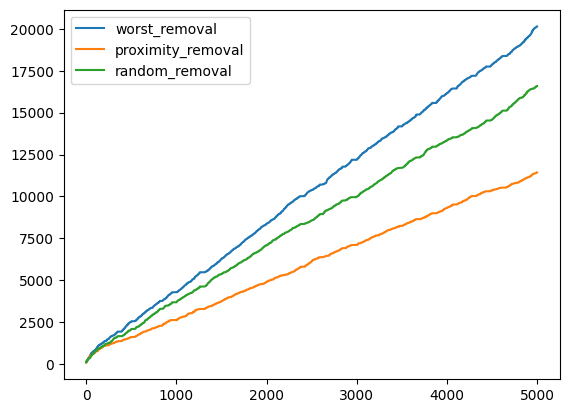

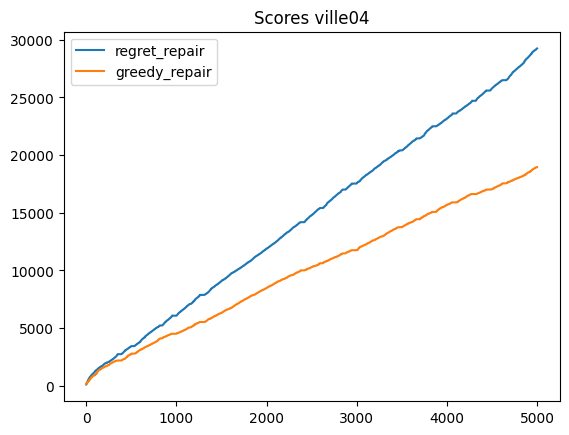

In [ ]:
plot.plot(close_depot_scores)
plot.plot(open_depot_scores)
plot.plot(swap_depot_scores)
plot.legend(["close_depot","open_depot","swap_depot"])
plot.show()
plot.plot(worst_removal_aleatoire_scores)
plot.plot(proximity_removal_scores)
plot.plot(random_removal_scores)
plot.legend(["worst_removal","proximity_removal","random_removal"])
plot.show()
plot.plot(regret_repair_scores)
plot.plot(greedy_repair_optimised_perturbation_scores)
plot.title("Scores {}".format(nom_de_ville))
plot.legend(["regret_repair","greedy_repair"])
plot.show()

#création d'un gif pour voir la variation des solutions

cette partie créer des graphe qui represente chaque solution optimal retrouvé au cours des itérations

il faut créer un dossier "images" dans le workspace, le code telecharge l'ensemble des images,

il faut ensuite utiliser un GIFmaker pour voir l'animation

In [ ]:
"""
import imageio
from PIL import Image

image_path_list = []
test = lrp.LocationRoutingProblem(nom_de_ville,3,solutions_min[0])
# Génération des images individuelles
for i in range(len(solutions_min)):
    # Appel à la méthode pour tracer l'image avec la donnée correspondante
    print(i)
    test.solution = solutions_min[i]
    plot = test.plotData()

    # Chemin de sauvegarde de l'image
    image_path = f"/content/images/image_{i}.png"

    # Sauvegarde de l'image tracée
    plt.savefig(image_path)

    # Ajout du chemin de l'image à la liste
    image_path_list.append(image_path)
    plot.show()

# Chargement des images individuelles et création du GIF
images = []
for image_path in image_path_list:
    img = Image.open(image_path)
    images.append(img)
!zip -r /content/file.zip /content/images/
"""

'\nimport imageio\nfrom PIL import Image\n\nimage_path_list = []\ntest = lrp.LocationRoutingProblem(nom_de_ville,3,solutions_min[0])\n# Génération des images individuelles\nfor i in range(len(solutions_min)):\n    # Appel à la méthode pour tracer l\'image avec la donnée correspondante\n    print(i)\n    test.solution = solutions_min[i]\n    plot = test.plotData()\n\n    # Chemin de sauvegarde de l\'image\n    image_path = f"/content/images28/image_{i}.png"\n\n    # Sauvegarde de l\'image tracée\n    plt.savefig(image_path)\n\n    # Ajout du chemin de l\'image à la liste\n    image_path_list.append(image_path)\n    plot.show()\n\n# Chargement des images individuelles et création du GIF\nimages = []\nfor image_path in image_path_list:\n    img = Image.open(image_path)\n    images.append(img)\n!zip -r /content/file_28.zip /content/images28/\n'